# **Import Libraries**

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import warnings

warnings.filterwarnings('ignore')

# **Load Data**

In [9]:
file_path = '/content/drive/MyDrive/UIUC CS - JUNIOR/CS 441/Final Project/Data/raw_flight_data.csv'

# We need specific columns to replicate the group mate's logic
cols_to_load = [
    'FlightDate', 'Reporting_Airline', 'Origin', 'Dest',
    'CRSDepTime', 'DepDelay', 'ArrDelay', 'Cancelled', 'Distance',
    'LateAircraftDelay' # Crucial for the "Propagation" feature
]

try:
    df = pd.read_csv(file_path, usecols=lambda c: c in cols_to_load)
    print(f"Loaded {len(df):,} rows.")
except ValueError:
    print("Warning: 'LateAircraftDelay' might be missing. Loading without it...")
    cols_to_load.remove('LateAircraftDelay')
    df = pd.read_csv(file_path, usecols=cols_to_load)

# REPLICATION: Filter to the 5 Strategic Hubs she selected
# ORD=O'Hare, MDW=Midway, MKE=Milwaukee, DTW=Detroit, MSP=Minneapolis
strategic_hubs = ['ORD', 'MDW', 'MKE', 'DTW', 'MSP']
df = df[df['Origin'].isin(strategic_hubs)].copy()
print(f"Filtered to 5 Strategic Hubs: {len(df):,} rows.")

Loaded 539,747 rows.
Filtered to 5 Strategic Hubs: 46,497 rows.


# **Feature Engineering**

In [10]:
# A. Create Target Variable (0=OnTime, 1=Delay, 2=Cancel)
df['TARGET_CLASS'] = 0
df.loc[(df['ArrDelay'] > 15) & (df['Cancelled'] == 0), 'TARGET_CLASS'] = 1
df.loc[df['Cancelled'] == 1, 'TARGET_CLASS'] = 2

# B. Cyclical Time Encoding (Sin/Cos)
# Convert 1430 to minutes (14*60 + 30)
minutes = (df['CRSDepTime'] // 100) * 60 + (df['CRSDepTime'] % 100)
max_min = 24 * 60
df['DepTime_sin'] = np.sin(2 * np.pi * minutes / max_min)
df['DepTime_cos'] = np.cos(2 * np.pi * minutes / max_min)

# C. The "Smart" Feature: Lagged Delay Propagation
# We must sort by Time to calculate "previous flights"
df['FlightDate'] = pd.to_datetime(df['FlightDate'])
df['DayOfWeek'] = df['FlightDate'].dt.dayofweek # Add DayOfWeek here
df = df.sort_values(by=['Origin', 'Reporting_Airline', 'FlightDate', 'CRSDepTime'])

def calc_rolling(series, window=50):
    # Shift 1 (exclude current flight) -> Rolling Mean
    return series.shift(1).rolling(window=window, min_periods=1).mean()

# Use LateAircraftDelay if available, else fallback to DepDelay
delay_col = 'LateAircraftDelay' if 'LateAircraftDelay' in df.columns else 'DepDelay'

print("Generating Lagged Features (this takes a moment)...")
# Calculate rolling average of delay for this airline at this hub
df['Lagged_Bad_Weather_or_Late_Air'] = df.groupby(['Origin', 'Reporting_Airline'])[delay_col].transform(lambda x: calc_rolling(x))

# Calculate rolling average of "Target Class" (how often did they fail recently?)
df['Lagged_Failure_Rate'] = df.groupby(['Origin', 'Reporting_Airline'])['TARGET_CLASS'].transform(lambda x: calc_rolling(x))

# Fill NaNs (first 50 flights) with 0
df.fillna(0, inplace=True)

Generating Lagged Features (this takes a moment)...


# **SVM Preparation (Sampling & Scaling)**

In [11]:
# Define Features
features = [
    'DepTime_sin', 'DepTime_cos', 'Distance',          # Standard Features
    'Lagged_Bad_Weather_or_Late_Air', 'Lagged_Failure_Rate', # The "Smart" Features
    'Reporting_Airline', 'Dest', 'Origin', 'DayOfWeek' # Categoricals
]

X = df[features].copy()
y = df['TARGET_CLASS'].astype(int).copy()

# SAMPLING: SVM cannot handle millions of rows. We sample 50k.
if len(X) > 50000:
    X_sample, _, y_sample, _ = train_test_split(X, y, train_size=50000, stratify=y, random_state=42)
else:
    X_sample, y_sample = X, y

# Handling High Cardinality Destinations for SVM
# (Map non-top-20 destinations to 'Other' to prevent 300+ columns)
top_dests = X_sample['Dest'].value_counts().nlargest(20).index
X_sample['Dest'] = X_sample['Dest'].where(X_sample['Dest'].isin(top_dests), 'Other')

# **Pipeline & Training**

In [12]:
# Preprocessing: Scale Numbers, OneHot Categories
num_cols = ['DepTime_sin', 'DepTime_cos', 'Distance', 'Lagged_Bad_Weather_or_Late_Air', 'Lagged_Failure_Rate']
cat_cols = ['Reporting_Airline', 'Dest', 'Origin', 'DayOfWeek']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

# Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample)

# Transform
print("Preprocessing data...")
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# Train SVM
print("Training SVM (This may take 1-3 minutes)...")
svm = SVC(kernel='rbf', C=10, class_weight='balanced', random_state=42)
svm.fit(X_train_proc, y_train)

Preprocessing data...
Training SVM (This may take 1-3 minutes)...


SVC(C=10, class_weight='balanced', random_state=42)

# **Results**

In [13]:
print("\n--- Final SVM Results on Curated Data ---")
y_pred = svm.predict(X_test_proc)
print(classification_report(y_test, y_pred, target_names=['OnTime', 'Delayed', 'Cancelled']))


--- Final SVM Results on Curated Data ---
              precision    recall  f1-score   support

      OnTime       0.88      0.72      0.80      7349
     Delayed       0.35      0.53      0.42      1799
   Cancelled       0.12      0.47      0.19       152

    accuracy                           0.68      9300
   macro avg       0.45      0.57      0.47      9300
weighted avg       0.77      0.68      0.71      9300



# **Visualization**

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve

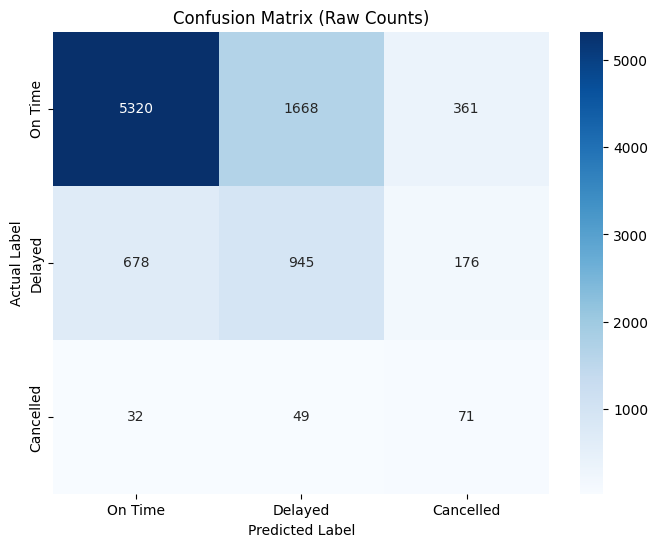

In [15]:
# ---------------------------------------------------------
# 1. Confusion Matrix (Raw Counts)
# ---------------------------------------------------------
# This answers: "How many actual flights did we get right?"
cm = confusion_matrix(y_test, y_pred)
labels = ['On Time', 'Delayed', 'Cancelled']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (Raw Counts)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

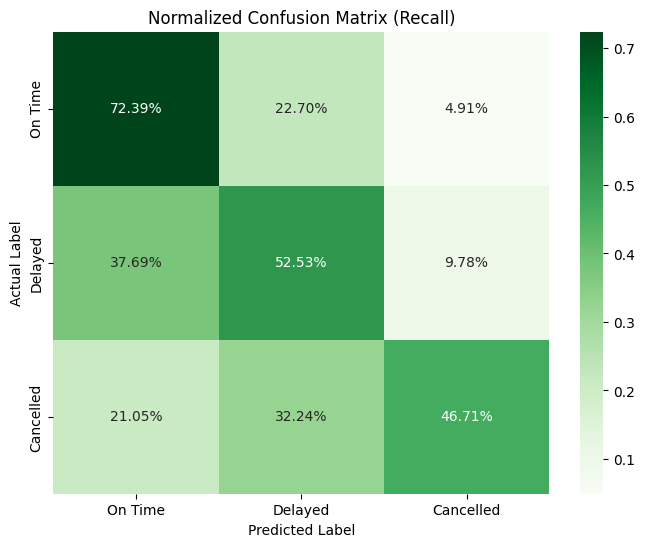

In [16]:
# ---------------------------------------------------------
# 2. Normalized Confusion Matrix (Recall Visualization)
# ---------------------------------------------------------
# This answers: "Of the flights that were ACTUALLY delayed, what % did we catch?"
# This is the most important chart for your "High Recall" narrative.
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.title('Normalized Confusion Matrix (Recall)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

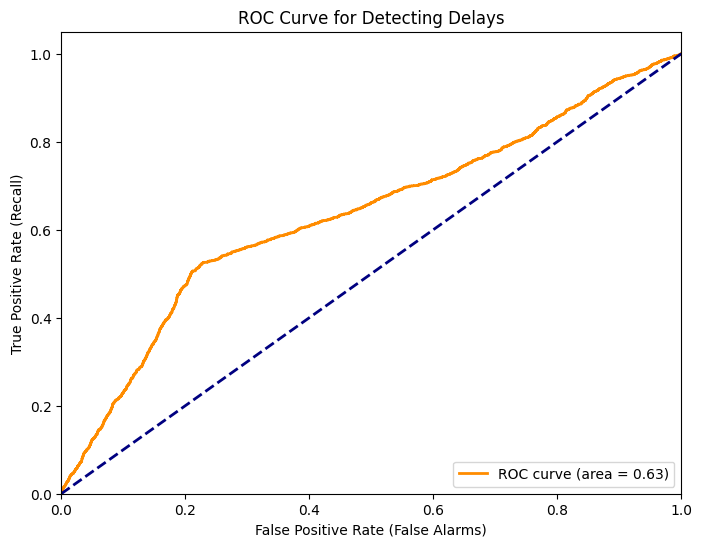

In [17]:
# ---------------------------------------------------------
# 3. ROC Curve (Focus on 'Delayed' Class)
# ---------------------------------------------------------
# This visualizes the trade-off between catching delays and false alarms.
# We treat 'Delayed' (Class 1) as the positive class.

# Get the probability scores for the "Delayed" class
# Note: SVC needs probability=True during training to use predict_proba.
# If you didn't set that, we use decision_function (distance to boundary).
if hasattr(svm, "predict_proba"):
    y_score = svm.predict_proba(X_test_proc)[:, 1]
else:
    # Use decision function score and normalize it roughly to 0-1 for plotting
    y_score = svm.decision_function(X_test_proc)
    # For multiclass, decision_function returns shape (n_samples, n_classes)
    # We want column 1 (Delayed) vs. others.
    # Note: If strategy is One-vs-One, this shape changes.
    # Simplification for plotting: We map y_test to binary (Delayed vs Not Delayed)

y_test_binary = (y_test == 1).astype(int)
# If y_score is multiclass, take the column corresponding to 'Delayed'
if y_score.ndim > 1:
    y_score = y_score[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_binary, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (False Alarms)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for Detecting Delays')
plt.legend(loc="lower right")
plt.show()

# **Model Optimization: Hyperparameter Tuning**

Finding the right `C` and `gamma` values can significantly boost SVM performance. Since SVMs are slow to train, we'll perform the search on a smaller subset of the data.

In [18]:
from sklearn.model_selection import GridSearchCV

# 1. Use a smaller subset for Hyperparameter Tuning to save time
tuning_sample_size = 5000
X_tune = X_train_proc[:tuning_sample_size]
y_tune = y_train[:tuning_sample_size]

# 2. Define the parameter grid
# C: Controls trade-off between smooth decision boundary and classifying training points correctly.
# gamma: Defines how far the influence of a single training example reaches.
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.1, 0.01]
}

print(f"Running GridSearchCV on {tuning_sample_size} samples... (This might take a minute)")
grid = GridSearchCV(SVC(kernel='rbf', class_weight='balanced', random_state=42),
                    param_grid,
                    cv=3,
                    scoring='f1_weighted',
                    n_jobs=-1)

grid.fit(X_tune, y_tune)

print("\n--- Best Parameters Found ---")
print(grid.best_params_)
print(f"Best Cross-Validation F1 Score: {grid.best_score_:.3f}")

# Suggestion for next step
print(f"\nTip: You can now re-train your full model using these parameters:")
print(f"svm_optimized = SVC(kernel='rbf', C={grid.best_params_['C']}, gamma='{grid.best_params_['gamma']}', class_weight='balanced')")

Running GridSearchCV on 5000 samples... (This might take a minute)

--- Best Parameters Found ---
{'C': 0.1, 'gamma': 0.01}
Best Cross-Validation F1 Score: 0.715

Tip: You can now re-train your full model using these parameters:
svm_optimized = SVC(kernel='rbf', C=0.1, gamma='0.01', class_weight='balanced')


# Task
Train a new SVC model with `kernel='rbf'`, `C=0.1`, `gamma=0.01`, and `class_weight='balanced'` using the preprocessed training data `X_train_proc` and `y_train`. After training, predict the labels for `X_test_proc` and display the classification report comparing the predictions with `y_test`.

## Re-train SVM with optimized parameters

### Subtask:
Instantiate and train a new SVC model with the optimized hyperparameters on the full training set.


**Reasoning**:
Instantiate and train the SVM model using the optimized hyperparameters found in the previous grid search.



In [19]:
print("Training Optimized SVM (This may take a few minutes)...")

# Instantiate the model with optimized hyperparameters
svm_optimized = SVC(kernel='rbf',
                    C=0.1,
                    gamma=0.01,
                    class_weight='balanced',
                    random_state=42)

# Fit the model on the full training set
svm_optimized.fit(X_train_proc, y_train)

print("Training completed.")

Training Optimized SVM (This may take a few minutes)...
Training completed.


**Reasoning**:
Now that the optimized SVM model is trained, predict the labels for the test set and display the classification report to evaluate performance as requested.



In [20]:
print("\n--- Final SVM Results on Optimized Model ---")
y_pred_optimized = svm_optimized.predict(X_test_proc)
print(classification_report(y_test, y_pred_optimized, target_names=['OnTime', 'Delayed', 'Cancelled']))


--- Final SVM Results on Optimized Model ---
              precision    recall  f1-score   support

      OnTime       0.87      0.74      0.80      7349
     Delayed       0.35      0.31      0.33      1799
   Cancelled       0.07      0.65      0.12       152

    accuracy                           0.66      9300
   macro avg       0.43      0.57      0.42      9300
weighted avg       0.76      0.66      0.70      9300



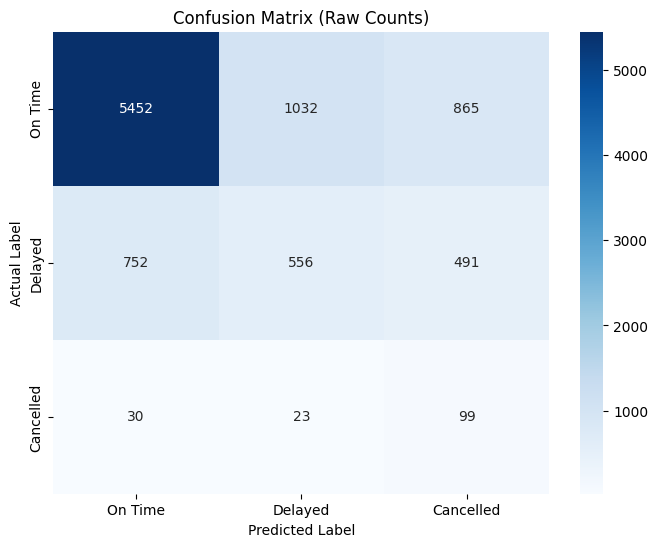

In [22]:
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
labels = ['On Time', 'Delayed', 'Cancelled']

plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (Raw Counts)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

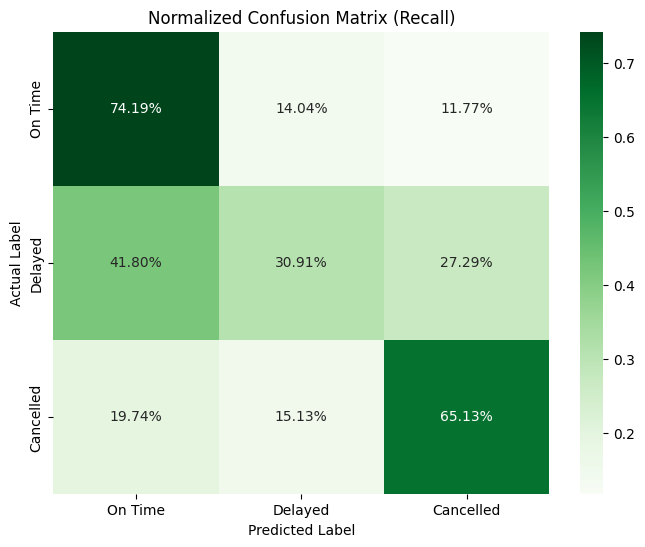

In [23]:
cm_norm_optimized = confusion_matrix(y_test, y_pred_optimized, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm_optimized, annot=True, fmt='.2%', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.title('Normalized Confusion Matrix (Recall)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()